In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(10, 5))
# plt.rc('font', size=12)

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import acquire as a 
import prepare as p

In [13]:
df = pd.read_csv("saas.csv")
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [11]:
# no nulls 
df.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [16]:
# update column names to lowercases
df.columns = df.columns.str.lower()

In [21]:
# update date data type
df.month_invoiced = df.month_invoiced.astype('datetime64')

In [27]:
# set time to index
df = df.set_index('month_invoiced')
df = df.sort_index()

KeyError: "None of ['month_invoiced'] are in the columns"

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [42]:
df_resampled = df.resample('m')[['amount']].sum()

# # Drop February 29th from our dataset (a leap year date)
# df_resampled = df_resampled[df_resampled.index != '2016-02-29']

df_resampled.head()


,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [43]:
train_size = int(len(df_resampled) * .5)
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]



2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:

    * Last Observed Value
    * Simple Average
    * Moving Average
    * Holt's Linear Trend
    * Holt's Seasonal Trend
    * Based on previous year/month/etc., this is up to you.

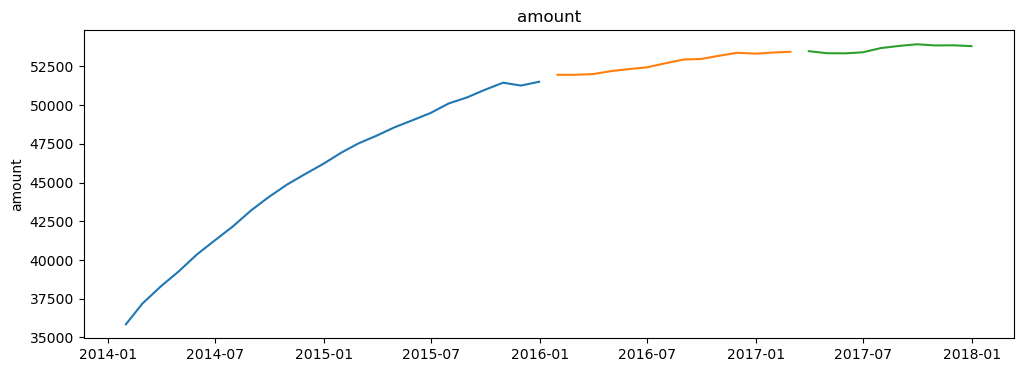

In [44]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [45]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [46]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [47]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


In [48]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])


# Last Observed Value

In [60]:
# take the last item of sales total and assign to variable
last_sales = train['amount'][-1:][0]

yhat_df = pd.DataFrame(
    {'amount': [last_sales]},
    index=validate.index)

yhat_df.head()


,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


In [62]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = "amount")


In [63]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


# Simple Average

In [67]:
# compute simple average of sales_total (from train data)
avg_amount = round(train['amount'].mean(), 2)


yhat_df = pd.DataFrame({'amount': [avg_amount]},
                        index=validate.index)

yhat_df.head(3)


,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54


amount -- RMSE: 7181


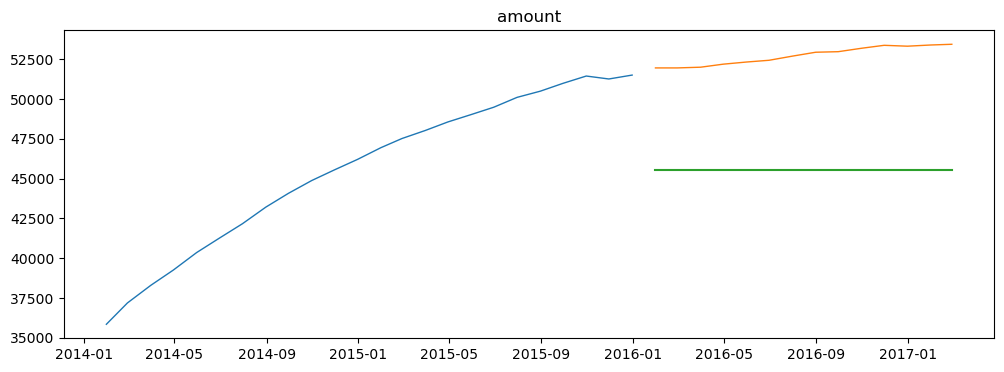

In [68]:
plot_and_eval('amount')


In [69]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = "amount")
eval_df


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0


# Moving Average

In [71]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 12

rolling_amount = round(train['amount'].rolling(period).mean()[-1], 2)


# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': rolling_amount},
                         index=validate.index)
yhat_df.head()


,amount
month_invoiced,
2016-01-31,49612.92
2016-02-29,49612.92
2016-03-31,49612.92
2016-04-30,49612.92
2016-05-31,49612.92


In [73]:
eval_df = append_eval_df(model_type='12 month moving average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0
0,12 month moving average,amount,3164.0
0,12 month moving average,amount,3164.0


# Holt's Linear Trend

In [74]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [76]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51748.62
2016-02-29,51961.99
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04


In [77]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)


In [78]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
0,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
0,12 month moving average,amount,3164.0
0,12 month moving average,amount,3164.0
0,simple_average,amount,7181.0


# Holt's Seasonal Trend

In [80]:
# Models for amount
hst_quantity_fit1 = ExponentialSmoothing(train.amount, seasonal_periods=365, trend='add', seasonal='add').fit()
# hst_quantity_fit2 = ExponentialSmoothing(train.amount, seasonal_periods=365, trend='add', seasonal='mul').fit()
# hst_quantity_fit3 = ExponentialSmoothing(train.amount, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
# hst_quantity_fit4 = ExponentialSmoothing(train.amount, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.